## In this notebook, we are using the Segmentation Models Pytorch package
* Basically a great API wrapper for segmentation modeling
* Following this example https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb from PyTorch to get started and adapting to our dataset.
* This package allows for quick iteration between model backbones.

### Imports

In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from PIL import Image
import cv2

import time, math
import os
from tqdm.notebook import tqdm

In [3]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on Device: ", device)

random_seed = 42
torch.manual_seed(random_seed)
print(device)
if (device != "cpu"):
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(random_seed)
np.random.seed(random_seed) #if you use numpy

Training on Device:  cuda
cuda


Creating Data Loaders

Total Images:  4221
Train Size   :  3228
Val Size     :  570
Test Size    :  423
Image Size (1024, 1024)
Mask Size (1024, 1024)


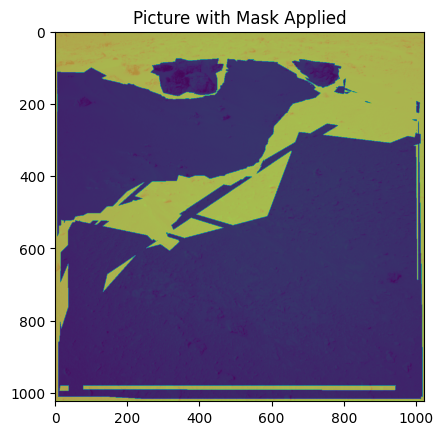

In [4]:
IMAGE_PATH = 'C:/Users/Shoon/repos/DGMDE-17-Final-Project/data/spaceData/Images/'
MASK_PATH = 'C:/Users/Shoon/repos/DGMDE-17-Final-Project/data/spaceData/Masks/'

n_classes = 4

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

# Let's view an image

img = Image.open(IMAGE_PATH + df['id'][100] + '.JPG')
mask = Image.open(MASK_PATH + df['id'][100] + '.PNG')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Applied')
plt.show()

In [5]:
class MarsDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.JPG', cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.PNG', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches


In [6]:
mean = [0.25362933664907805]#, 0.25362933664907805, 0.25362933664907805]
std = [0.1054563979418538]#, 0.1054563979418538, 0.1054563979418538]

#datasets
train_set = MarsDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std)
val_set = MarsDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std)
test_set = MarsDataset(IMAGE_PATH, MASK_PATH, X_test, mean, std)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)
test_loader = DataLoader(val_set, batch_size=1)

### Defining the UNet model

In [7]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

### Defining constants and model instantiation

In [8]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['soil', 'bedrock', 'sand', 'bigrock']

ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1, # B/W
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Training the model

In [9]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.losses import *

loss = DiceLoss() # F1 score
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [10]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model 
NUM_EPOCHS = 40

max_score = 0
train_log_list = []
valid_log_list = []

for i in range(0, NUM_EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    print('train_logs', train_logs)
    print('valid_logs', valid_logs)
    train_log_list.append(train_logs)
    valid_log_list.append(valid_logs)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_bw.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


In [ ]:
# Save model

In [ ]:
train_log_list

### TEST THE BEST SAVED MODEL

In [14]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

### Visualize Results

In [ ]:
import torch.nn.functional as F

def predicted_mask(model,image):
    
    model.to(device)
    image = image.to(device)
    output = model.predict(image)
    
    #applying softmax and choosing best class with argmax
    output = F.softmax(output, dim=1) #on all colors
    output = torch.argmax(output, dim=1) #on all colors
    
    return output

n = 50

image, gt_mask = test_set[n]
array_image = np.array(image)
x_tensor = torch.from_numpy(array_image).to(DEVICE).unsqueeze(0)
predicted_best = predicted_mask(best_model, x_tensor)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image.squeeze(), cmap = "gray")
ax[0].imshow(gt_mask, alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image.squeeze(), cmap = "gray")
ax[1].imshow(predicted_best.cpu().view(1024,1024), alpha = 0.5, cmap = "brg",vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Best)')

### Calculate Metrics

Utilities

In [ ]:
# Let's move the training and testing images/masks to separate folders
print(df_train.head())

In [ ]:
IMAGE_PATH = "./data/ai4mars-dataset-merged-0.1/msl/images/edr/"
MASK_PATH_TRAIN = "./data/ai4mars-dataset-merged-0.1/msl/labels/train/"
MASK_PATH_TEST = "./data/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min3-100agree/"

In [ ]:
import shutil

OUT_PATH = "./data/spaceData/Masks"

for image_name in df_train['id']:
    image_name = image_name + ".PNG"
    image_path = os.path.join(MASK_PATH_TRAIN, image_name,)
    new_path = os.path.join(OUT_PATH, image_name)

    # try:
    shutil.copy(image_path, new_path)
    print("File copied successfully.")

    # except:
    #     print('not able to copy file')